---

## 1. Imports

In [1]:
import utils

# Import libraries
# PyTorch for building and training neural networks
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from torch import Tensor

# Torchvision for data transformations
import torchvision
from torchvision import datasets, transforms

# Torchinfo to display model summaries
from torchinfo import summary

# Numpy and Pathlib for data handling
import numpy as np
from pathlib import Path

# Tqdm for progress bars
from tqdm.auto import tqdm

# Scikit-learn for splitting datasets
from sklearn.model_selection import train_test_split

import os
from typing import Optional, Union, Tuple

# Monai for medical imaging, specific to preprocessing and loss functions
import monai
from monai.transforms import LoadImage
from monai.losses import DiceLoss

from dotenv import load_dotenv
import nibabel as nib
from PIL import Image
import SimpleITK as sitk

# Matplotlib for data visualization
# import matplotlib
import matplotlib.pyplot as plt
# from matplotlib.colors import ListedColormap
# %matplotlib inline

# Check and display library versions for reproducibility
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Monai version: {monai.__version__}")

c:\Users\agmau\miniforge3\envs\prjiav_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.9.1+cu126
Torchvision version: 0.24.1+cu126
Numpy version: 2.3.3
Monai version: 1.5.1


In [2]:
# Device setup
# Use GPU if available for faster training, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


---

## 2. Check data

In [3]:
load_dotenv()

try:
    preprocessed_data_dir = os.getenv("PREPROCESSED_DATA_DIR")
    print("Data at:", preprocessed_data_dir)
    train_data_dir = os.getenv("TRAIN_DATA_DIR")
    print("Train data at:", train_data_dir)
    test_data_dir = os.getenv("TEST_DATA_DIR")
    print("Test data at:", test_data_dir)
except Exception as e:
    print(str(e))

Data at: C:/Users/agmau/OneDrive/Documents/INSA_Lyon/5A/PRJIAV/PRJIAV-Segmentation/data/MSLesSeg_Dataset
Train data at: C:/Users/agmau/OneDrive/Documents/INSA_Lyon/5A/PRJIAV/PRJIAV-Segmentation/data/MSLesSeg_Dataset/train
Test data at: C:/Users/agmau/OneDrive/Documents/INSA_Lyon/5A/PRJIAV/PRJIAV-Segmentation/data/MSLesSeg_Dataset/test


In [4]:
train_datalist = utils.datalist(train_data_dir)
test_datalist = utils.datalist(test_data_dir)

print("Example of train keys: ", train_datalist[:1])
print("Example of test keys: ", test_datalist[:1])

Example of train keys:  [{'image': 'C:/Users/agmau/OneDrive/Documents/INSA_Lyon/5A/PRJIAV/PRJIAV-Segmentation/data/MSLesSeg_Dataset/train/P1/T1/P1_T1_FLAIR.nii.gz', 'label': 'C:/Users/agmau/OneDrive/Documents/INSA_Lyon/5A/PRJIAV/PRJIAV-Segmentation/data/MSLesSeg_Dataset/train/P1/T1/P1_T1_MASK.nii.gz'}]
Example of test keys:  [{'image': 'C:/Users/agmau/OneDrive/Documents/INSA_Lyon/5A/PRJIAV/PRJIAV-Segmentation/data/MSLesSeg_Dataset/test/P54/P54_FLAIR.nii.gz', 'label': 'C:/Users/agmau/OneDrive/Documents/INSA_Lyon/5A/PRJIAV/PRJIAV-Segmentation/data/MSLesSeg_Dataset/test/P54/P54_MASK.nii.gz'}]


In [5]:
class SITKResize3D:
    def __init__(self, new_size):   
        """
        new_size = (D, H, W)  taille voulue pour le volume 3D
        """
        self.new_size = new_size

    def __call__(self, volume, is_mask=False):
        # Convert numpy → SITK image si besoin
        if isinstance(volume, np.ndarray):
            image = sitk.GetImageFromArray(volume)
        else:
            image = volume

        original_size = np.array(image.GetSize(), dtype=np.int32)      # (W, H, D)
        new_size = np.array(self.new_size[::-1], dtype=np.int32)       # sitk = (W,H,D)

        # Facteurs de mise à l'échelle
        original_spacing = image.GetSpacing()
        new_spacing = original_spacing * (original_size / new_size)

        # Interpolation
        interpolator = (
            sitk.sitkNearestNeighbor if is_mask else sitk.sitkLinear
        )

        # Resampleur
        resampler = sitk.ResampleImageFilter()
        resampler.SetSize(new_size.tolist())
        resampler.SetOutputSpacing(new_spacing.tolist())
        resampler.SetOutputDirection(image.GetDirection())
        resampler.SetOutputOrigin(image.GetOrigin())
        resampler.SetInterpolator(interpolator)

        resized_img = resampler.Execute(image)

        # Retour numpy en shape (D,H,W)
        return sitk.GetArrayFromImage(resized_img)


class MSLesSegDataset(Dataset):
    def __init__(self, datalist, new_shape, limit=None):
        
        self.images = [item["image"] for item in datalist]
        self.masks  = [item["label"] for item in datalist]

        if limit is not None:
            self.images = self.images[:limit]
            self.masks  = self.masks[:limit]

        self.resize = SITKResize3D(new_shape)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        
        # --- Lire l'image avec sitk ---
        img_sitk  = sitk.ReadImage(self.images[index])
        mask_sitk = sitk.ReadImage(self.masks[index])

        # Conversion en numpy (D,H,W)
        img  = sitk.GetArrayFromImage(img_sitk).astype(np.float32)
        mask = sitk.GetArrayFromImage(mask_sitk).astype(np.float32)

        # Normaliser l'image entre 0 et 1
        img = img / (np.max(img) + 1e-8)

        # Resize 3D
        img  = self.resize(img,  is_mask=False)
        mask = self.resize(mask, is_mask=True)

        # Binariser masque
        mask = (mask > 0).astype(np.float32)

        # Convertir en tenseur PyTorch (C,D,H,W)
        img  = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return img, mask, self.images[index]

In [6]:
# How many samples per batch to load
batch_size = 32
depth = 64
width =  64      # new size of the images
height = 64

# Choose the training and test datasets
train_dataset = MSLesSegDataset(train_datalist, new_shape=(depth, height, width))
test_dataset = MSLesSegDataset(test_datalist, new_shape=(depth, height, width))

# Prepare data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 279
Test dataset size: 66


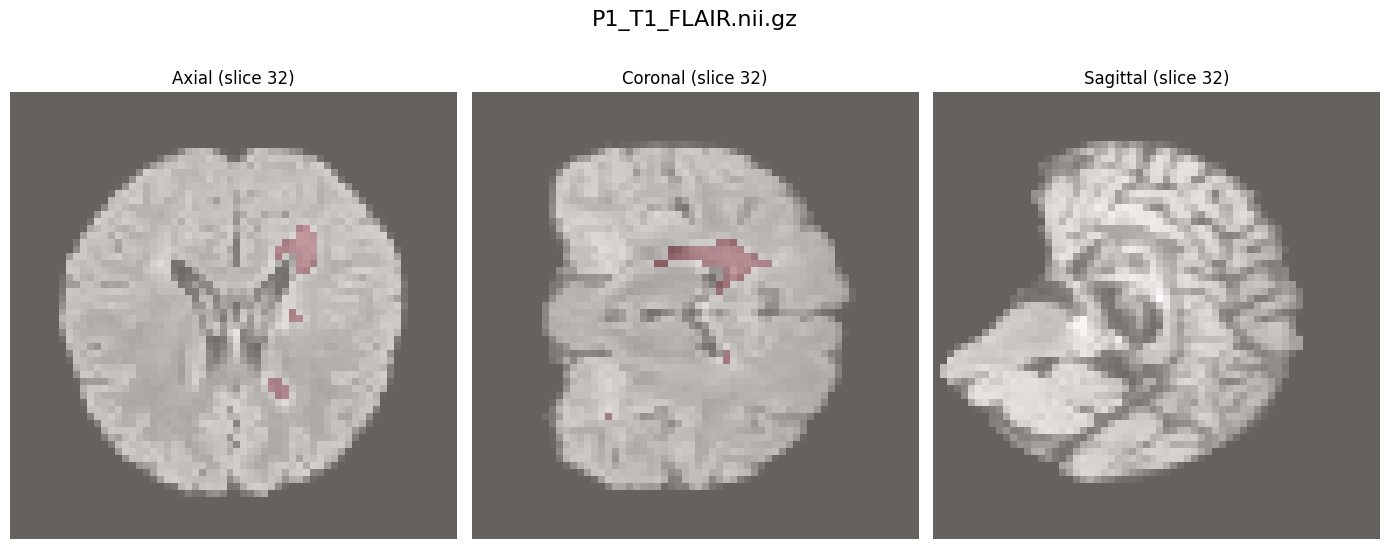

In [7]:
img, mask, path = train_dataset[0]

utils.show_3d_views(img, mask, title=os.path.basename(path))

---

## 3. Network Architecture

In [8]:
from monai.networks.nets import UNet

# Define a Unet with  monai, lighter than Class Unet 
# Creation of the model U-Net with MONAI
model = UNet(
    spatial_dims = 3,                 # 3D U-Net
    in_channels = 1,                  # Canaux d'entrée (niveaux de gris ou RGB)
    out_channels = 1,                 # Canaux de sortie (classes de segmentation)
    channels = (16, 32, 64, 128),     # Nombres de canaux aux différents niveaux d'encodage
    strides = (2, 2, 2),              # Strides de downsampling
    num_res_units=1                   # Nombre d'unités résiduelles par bloc
).to(device)

In [9]:
# Print the summary of the network
summary_kwargs = dict(
    col_names=["input_size", "output_size", "kernel_size", "num_params"], depth=4, verbose=0
)
summary(model, input_size = (batch_size, 1, depth, width, height),  device=device, **summary_kwargs)

Layer (type:depth-idx)                                                           Input Shape               Output Shape              Kernel Shape              Param #
UNet                                                                             [32, 1, 64, 64, 64]       [32, 1, 64, 64, 64]       3                         --
├─Sequential: 1-1                                                                [32, 1, 64, 64, 64]       [32, 1, 64, 64, 64]       --                        --
│    └─ResidualUnit: 2-1                                                         [32, 1, 64, 64, 64]       [32, 16, 32, 32, 32]      --                        --
│    │    └─Conv3d: 3-1                                                          [32, 1, 64, 64, 64]       [32, 16, 32, 32, 32]      [3, 3, 3]                 448
│    │    └─Sequential: 3-2                                                      [32, 1, 64, 64, 64]       [32, 16, 32, 32, 32]      --                        --
│    │    │    └─Convo